In [1]:
import multiprocessing as mp
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import DMdecay as dmd
import JWSTutils as jwst
from gnz11_split import partition_gnz11

In [2]:
run_dir = "gnz11_split"
prev_config_path = F"{run_dir}/gnz11_split.toml"
skipping = 1

dofs = [5, 15]

In [3]:
prev_configs = dmd.prep.parse_configs(prev_config_path)
run_name = prev_configs["run"]["name"]

data = jwst.process_datafiles(prev_configs["run"]["paths"], 
                                prev_configs["system"]["res_path"])
data = partition_gnz11(data, prev_configs["run"]["lambda_min"],
                        prev_configs["run"]["lambda_split"])
for spec in data:
    dmd.prep.doppler_correction(spec, prev_configs["halo"])
    dmd.prep.add_Dfactor(spec, prev_configs["halo"])

parsing gnz11_split/gnz11_split.toml
processing 2 datafiles...


In [4]:
rawlimits = np.loadtxt(
    F"{run_name}/{prev_configs['run']['rawlimits_filename']}")
valid = np.isfinite(rawlimits[:, 1])
masses_to_test = rawlimits[valid, :][::skipping, 0]
lams_to_test = dmd.conversions.mass_to_wavelength(masses_to_test)

In [5]:
def get_limit(num_knots, data, prev_configs, lam_test):
    prev_configs["analysis"]["num_knots"] = num_knots
    raw_out = dmd.linesearch.find_raw_limit(prev_configs, data, lam_test)
    [[lmin, lmax], 
    spec_list, 
    knots, 
    error_scale_factors,
    [limit_rate, limit_knots], 
    [best_rate, best_knots],
    delta_chisq,
    lam_list_msk, 
    error_list_msk, 
    lam0_tmp,
    sky_list, 
    lam_list, 
    error_list, 
    fixed_list, 
    spec_list, 
    res_list, 
    mask_list, 
    sky_list_msk] = raw_out
    limit_decayrate = dmd.conversions.fluxscale_to_invsec(limit_rate)   
    mass_test = dmd.conversions.wavelength_to_mass(lam_test)
    limit_g = dmd.conversions.decayrate_to_axion_g(limit_decayrate,
                                                    mass_test) 
    return limit_g

In [6]:
limits_dict = {n:np.full(masses_to_test.size, np.nan) for n in dofs}
for i, num_knots in enumerate(dofs):
    print(F"Fitting with {num_knots} knots")
    wrapper = partial(get_limit, num_knots, data, prev_configs)
    with mp.Pool(mp.cpu_count() - 1) as pool:
        results_iter = tqdm(pool.imap(wrapper, lams_to_test), 
                        total=lams_to_test.size)
        limits_dict[num_knots] = np.asarray(list(results_iter))

Fitting with 5 knots


100%|██████████| 905/905 [00:37<00:00, 24.08it/s]

Fitting with 15 knots



100%|██████████| 905/905 [03:43<00:00,  4.04it/s]


In [81]:

limits_df = pd.DataFrame(limits_dict)
limits_df["mass"] = masses_to_test
avg = (limits_df[5] + limits_df[15])*0.5
limits_df["frac_diff"] = (limits_df[5] - limits_df[15])/avg

limits_df["ratio"] = limits_df[5]/limits_df[15]
limits_df["abs_log_ratio"] = np.abs(np.log10(limits_df["ratio"]))

In [82]:

limits_df.to_csv(F"{run_name}/continuum-compare-limits.csv", index=False)

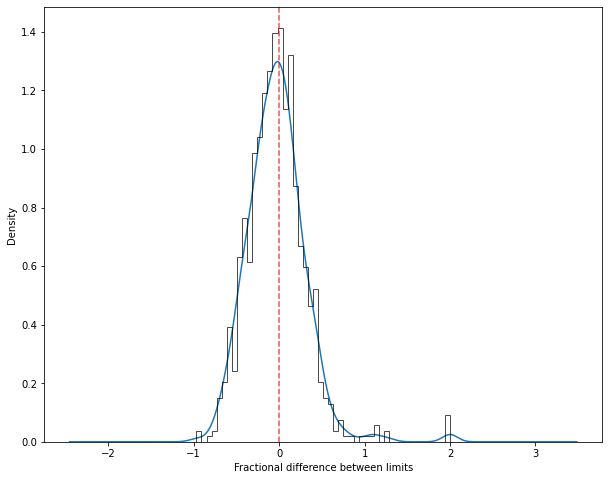

In [83]:
ax = limits_df["frac_diff"].plot(kind="density",
                                 figsize=(10, 8))
ax.hist(limits_df["frac_diff"], bins=50, density=True,
        alpha=0.7, color='black', histtype="step")
ax.set_xlabel("Fractional difference between limits")
ax.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.savefig(F"{run_name}/continuum-compare-limits.png")

In [96]:
limits_df["lam"] = lams_to_test

sorted = limits_df.sort_values("frac_diff")
print(sorted[:10][["mass", "lam", "frac_diff"]] )
print(sorted[-10:][["mass", "lam", "frac_diff"]] )

         mass       lam  frac_diff
904  0.783089  3.166536  -0.968481
457  1.325493  1.870761  -0.953928
456  1.327141  1.868437  -0.793390
67   2.253600  1.100320  -0.788622
717  0.970367  2.555405  -0.759157
742  0.942590  2.630710  -0.728172
778  0.904184  2.742450  -0.724222
716  0.971497  2.552431  -0.715873
460  1.320563  1.877745  -0.711354
854  0.828815  2.991839  -0.701680
         mass       lam  frac_diff
410  1.405870  1.763804   1.112331
682  1.010868  2.453021   1.127179
40   2.349081  1.055596   1.140460
13   2.450887  1.011748   1.272017
58   2.284762  1.085312   1.274665
676  1.018007  2.435817   1.999990
519  1.228115  2.019095   1.999997
402  1.420167  1.746048   1.999997
397  1.429198  1.735015   1.999998
93   2.167080  1.144249   2.000000


In [85]:
limits_df["abs_log_ratio"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

0.100    0.014745
0.250    0.042335
0.500    0.088874
0.750    0.161792
0.900    0.227352
0.990    0.543656
0.999    6.438526
Name: abs_log_ratio, dtype: float64

In [89]:
O1_logratios = limits_df[limits_df["abs_log_ratio"] < 1]["abs_log_ratio"]

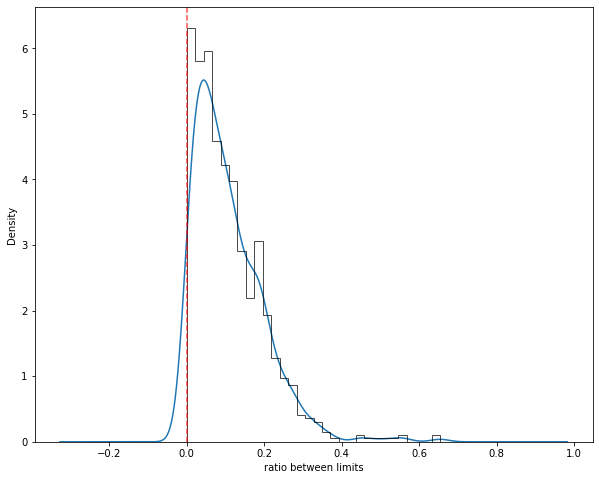

In [92]:
ax_ratio = O1_logratios.plot(kind="density",
                                 figsize=(10, 8))
ax_ratio.hist(O1_logratios, bins=30, density=True,
        alpha=0.7, color='black', histtype="step")
ax_ratio.set_xlabel("ratio between limits")
ax_ratio.axvline(0, color="red", linestyle="--", alpha=0.7)
plt.savefig(F"{run_name}/continuum-compare-limits-ratio.png")

In [100]:
print(np.sum(limits_df["abs_log_ratio"] > 1))
limits_df[limits_df["abs_log_ratio"] > 1][["lam", 5, 15, "ratio"]]

5


,lam,5,15,ratio
93,1.144249,1.583057e-11,1.027056e-19,1.541353e+08
397,1.735015,1.612008e-11,9.007739e-18,1.789581e+06
402,1.746048,2.390545e-11,1.569768e-17,1.522865e+06
519,2.019095,1.698105e-11,1.372384e-17,1.237340e+06
676,2.435817,3.443288e-11,8.318613e-17,4.139257e+05


In [ ]:
limits_dict

{5: array([3.04468148e-11, 2.60216566e-11, 2.17618921e-11, 1.34817522e-11,
        2.91893840e-11, 1.34726765e-11, 3.44763948e-11, 4.85266451e-11,
        5.15251757e-11, 3.43695152e-11, 1.64928885e-11, 2.80626421e-11,
        1.60089699e-11, 4.58423657e-11, 4.03162492e-11, 4.96873863e-11,
        3.85945185e-11, 4.94607181e-11, 6.36878873e-11])}